Quora Question pair Dataset - https://www.kaggle.com/c/quora-question-pairs/data

## Objective

* To distinguish the question pair are they same or different. 
* Here result must be probability score , not on 1 or 0. So as to decide the threshold
* Log Loss to measure performence - As we are using Probability scores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re

In [2]:
path = "D:\\Data Science\\Projects\\Quara question pair\\quora-question-pairs\\train.csv"

df = pd.read_csv(path)

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [7]:
df.groupby('is_duplicate').count()

,id,qid1,qid2,question1,question2
is_duplicate,,,,,
0,255027,255027,255027,255026,255025
1,149263,149263,149263,149263,149263


### Data Distribution in O/P classes

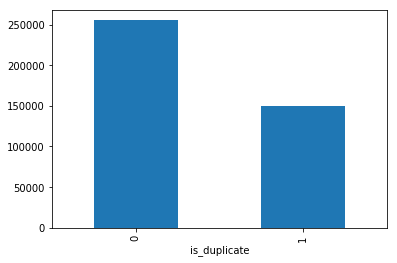

In [8]:
# Checking dataset balancing

id_grp = df.groupby('is_duplicate').count()['id']
id_grp.plot.bar()

In [9]:
print("Total numer of question pair = {}".format(len(df)))
print("Number of duplicate pairs = %f"%(id_grp[0]/len(df)*100))
print("Number of distinct pairs = %f"%(id_grp[1]/len(df)*100))

Total numer of question pair = 404290
Number of duplicate pairs = 63.080215
Number of distinct pairs = 36.919785


### Checking for null values

In [10]:
df[df.isnull().any(1)]  #reprent the datapoints having null values anywhere

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [11]:
# replacing NA values with ' '

df = df.fillna(' ')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### Unique Ques

In [12]:
# Number of unique questions

a = df.qid1.tolist()
b = df.qid2.tolist()
unique_ids = len(np.unique(np.array(a+b)))
unique_ids

537933

In [13]:
# Question repeated more then one

repeated_ids = np.sum(pd.Series(a+b).value_counts()>1)
repeated_ids

111780

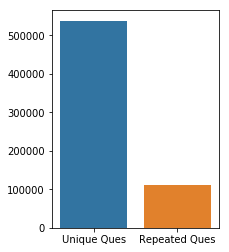

In [14]:
x = ["Unique Ques",'Repeated Ques']
y = [unique_ids,repeated_ids]
plt.figure(figsize=(3,4))
sns.barplot(x,y)
plt.show()

### Basic Featurization

In [15]:
def word_share(row):
    word_common = set(row.question1.strip(" ").split(" ") + row.question2.strip(" ").split(' '))
    word_total = row.question1.strip(" ").split(' ') + row.question2.strip(" ").split(' ')
    return len(word_common)/len(word_total)

df['word_share'] = df.apply(word_share,axis=1)

In [16]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.500000
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.761905
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.875000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.950000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.900000


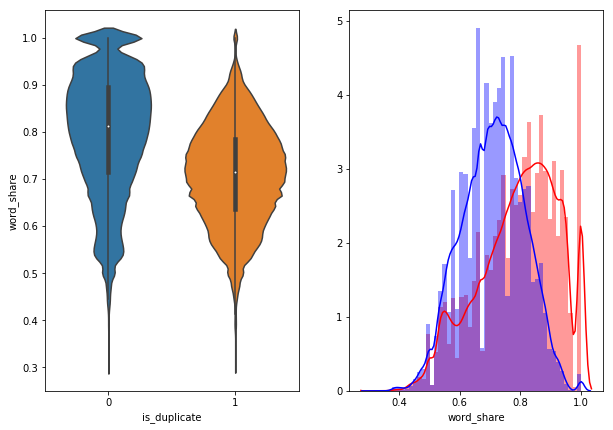

In [17]:
# Checking wether it is useful by plotting vilon and PDF 

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y ='word_share',data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==0]['word_share'], label=0, color='red')
sns.distplot(df[df['is_duplicate']==1]['word_share'], label=1, color='blue')
plt.show()

### Text Preprocessing

* Removal of HTML tags, Punctuations, Stemming, stopwords

In [18]:
# impoting stopword from nltk.corpus
stop_words = stopwords.words("english")

stop_words.append("said")
stop_words.append("br")
stop_words.append(" ")

In [19]:
# importing porter stemmer from nltk.stem
from nltk.stem import PorterStemmer
porter_stem = PorterStemmer() 

from bs4 import BeautifulSoup

In [35]:
# using 're' regex

def preprocess(x):
    x = str(x).lower()
    # for removing html tag
    x = re.sub(re.compile(r'<.*?>'),' ',x)
    
    
    # expanding contractions
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    
#     if type(x) == type(''):
#         x = map(lambda x: snow_stem.stem(x),x.split(" ") )
#         x = " ".join(list(x))
    return x

In [36]:
df["question1"] = df["question1"].fillna("").apply(preprocess)
df["question2"] = df["question2"].fillna("").apply(preprocess)

In [37]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.500000
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.761905
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.875000
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.950000
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.900000


### Advance Feature Extraction

In [39]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

# for fuzzy geature extraction
from fuzzywuzzy import fuzz

In [57]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# def get_longest_substr_ratio(a, b):
#     strs = list(distance.lcsubstrings(a, b))
#     if len(strs) == 0:
#         return 0
#     else:
#         return len(strs[0]) / (min(len(a), len(b)) + 1)
    

def extract_features(df):
  
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
#     df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df
    
    
    

In [61]:
# applying advance featurizatio to dataframe and saving it into new csv file

df = extract_features(df)

path_save = "D:\\Data Science\\Projects\\Quara question pair\\quora-question-pairs\\new_feature_train.csv"
df.to_csv(path_save, index=False)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 21 columns):
id                    404290 non-null int64
qid1                  404290 non-null int64
qid2                  404290 non-null int64
question1             404290 non-null object
question2             404290 non-null object
is_duplicate          404290 non-null int64
word_share            404290 non-null float64
cwc_min               404290 non-null float64
cwc_max               404290 non-null float64
csc_min               404290 non-null float64
csc_max               404290 non-null float64
ctc_min               404290 non-null float64
ctc_max               404290 non-null float64
last_word_eq          404290 non-null float64
first_word_eq         404290 non-null float64
abs_len_diff          404290 non-null float64
mean_len              404290 non-null float64
token_set_ratio       404290 non-null int64
token_sort_ratio      404290 non-null int64
fuzz_ratio            404290 

### Extracted feature Analysis

In [62]:
df_duplicate = df[df.is_duplicate==1]
df_non_duplicate = df[df.is_duplicate==0]

In [78]:
# converting the {1},{2} --> {1,2,3,4..}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_non_duplicate["question1"], df_non_duplicate["question2"]]).flatten()

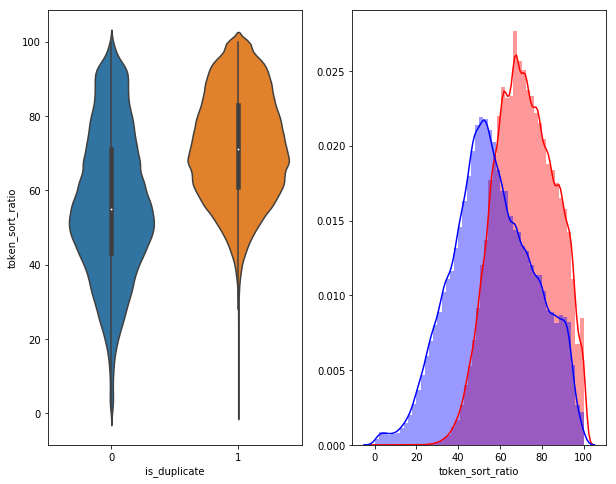

In [87]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate' ,y='token_sort_ratio' ,data=df)


plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )

plt.show()

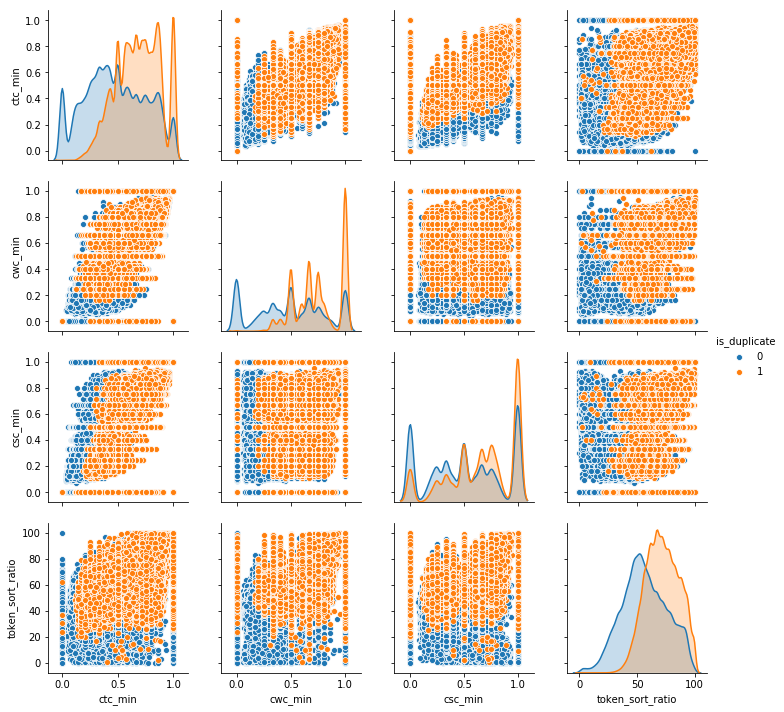

In [88]:
# n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

### TSNE visualization (2D)

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimentions

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000] # taking few samples only for dimensionaloty reduction
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

tsne2d = TSNE(n_components=2,init='random',random_state=101, method='barnes_hut',n_iter=1000,verbose=2, angle=0.5).fit_transform(X)
